In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [4]:
# Build the model

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense_1 = Dense(64, activation='relu')
    self.dense_2 = Dense(10)
    self.dense_3 = Dense(5)
    self.softmax = Softmax()

  def call(self, inputs, training=True):
    x = self.dense_1(inputs)
    y1 = self.dense_2(inputs)
    y2 = self.dense_3(y1)
    concat = concatenate([x, y2])
    return self.softmax(concat)

In [5]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  704       
_________________________________________________________________
dense_1 (Dense)              multiple                  110       
_________________________________________________________________
dense_2 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [8]:
# Create a custom layer
class MyLayer(Layer): 
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal')
    self.b = self.add_weight(shape=(units,),
                             initializer='zeros')
    
    def call(self, inputs):
      return tf.matmul(inputs, self.w)+self.b
    
dense_layer = MyLayer(3,5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)


tf.Tensor([[1. 1. 1. 1. 1.]], shape=(1, 5), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.06631041,  0.02681506, -0.10248406],
       [-0.02596821, -0.05684385, -0.01146787],
       [-0.06322274, -0.0444188 ,  0.04381816],
       [-0.07109677,  0.00847697,  0.02231237],
       [-0.08147101,  0.05429679,  0.06480951]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [9]:
# Specify trainable weights
class MyLayer(Layer): 
  def __init__(self, units, input_dim):
    super(MyLayer, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal', trainable=False)
    self.b = self.add_weight(shape=(units,),
                             initializer='zeros', trainable=False)
    
    def call(self, inputs):
      return tf.matmul(inputs, self.w)+self.b
    
dense_layer = MyLayer(3,5)


In [10]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [11]:
# Create a custom layer to accumulate means of output values
class MyLayerMean(Layer): 
  def __init__(self, units, input_dim):
    super(MyLayerMean, self).__init__()
    self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal')
    self.b = self.add_weight(shape=(units,),
                             initializer='zeros') 
    self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)), 
                                      trainable=False)
    self.number_call = tf.Variable(initial_value=0, trainable=False)
    
  def call(self, inputs):
    activations = tf.matmul(inputs, self.w)+self.b
    self.sum_activation.assign_add(tf.reduce_sum(activations, axis=0))
    self.number_call.assign_add(inputs.shape[0])
    return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)
    
dense_layer = MyLayerMean(3,5)


In [19]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[-0.10804909 -0.02754372 -0.12970631]
[-0.10804909 -0.02754372 -0.12970631]


In [20]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [21]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [22]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[6.8327581e-06 6.8327581e-06 3.7305595e-04 ... 6.8327581e-06
  3.7305595e-04 3.7305595e-04]], shape=(1, 10000), dtype=float32)
Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_11 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_6 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_12 (MyLayer)        multiple                  4160      
_________________________________________________________________
my_dropout_7 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_13 (MyLayer)        multiple                  2990      
_________________________________________________________________
softmax_4 (Softmax)          multiple            

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [23]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

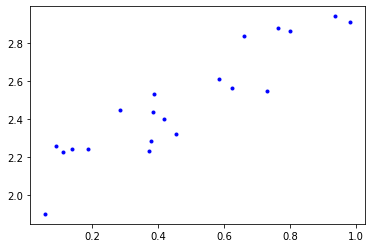

In [24]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [25]:
from tensorflow.keras.layers import Layer

In [26]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):
  def __init__(self):
    super(LinearLayer, self).__init__()
    self.m = self.add_weight(np.shape(1,), 
                             initializer='random_normal')
    self.b = self.add_weight(np.shape(1,), 
                             initializer='zeros')
  def call(self, inputs):
    return self.m*inputs + self.b

linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[-0.01245743 -0.02000535 -0.0234838  -0.00291695 -0.01212465 -0.00916193
 -0.00604398 -0.01881176 -0.03004247 -0.00355707 -0.00188619 -0.01199996
 -0.01458914 -0.02572304 -0.01347388 -0.02456651 -0.02118131 -0.00451517
 -0.01234985 -0.03151771], shape=(20,), dtype=float32)
[<tf.Variable ':0' shape=() dtype=float32, numpy=-0.03214238>, <tf.Variable ':0' shape=() dtype=float32, numpy=0.0>]


#### Define the loss function

In [27]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.33622


#### Train and plot the model

In [28]:
# Implement a gradient descent training loop for the linear regression model
learning_rate = 0.05
steps = 25

for i in range(steps):
  with tf.GradientTape() as tape: 
    predictions = linear_regression(x_train)
    loss = SquaredError(predictions, y_train)
  gradients = tape.gradient(loss, linear_regression.trainable_variables)
  linear_regression.m.assign_sub(learning_rate * gradients[0])
  linear_regression.b.assign_sub(learning_rate * gradients[1])
  print("Step %d, Loss %f" % (i, loss.numpy()))


Step 0, Loss 6.336220
Step 1, Loss 4.873423
Step 2, Loss 3.749021
Step 3, Loss 2.884731
Step 4, Loss 2.220381
Step 5, Loss 1.709718
Step 6, Loss 1.317188
Step 7, Loss 1.015463
Step 8, Loss 0.783537
Step 9, Loss 0.605263
Step 10, Loss 0.468230
Step 11, Loss 0.362897
Step 12, Loss 0.281930
Step 13, Loss 0.219693
Step 14, Loss 0.171854
Step 15, Loss 0.135081
Step 16, Loss 0.106814
Step 17, Loss 0.085086
Step 18, Loss 0.068385
Step 19, Loss 0.055546
Step 20, Loss 0.045677
Step 21, Loss 0.038091
Step 22, Loss 0.032259
Step 23, Loss 0.027776
Step 24, Loss 0.024330


m:1,  trained m:0.932673990726471
b:2,  trained b:1.955376148223877


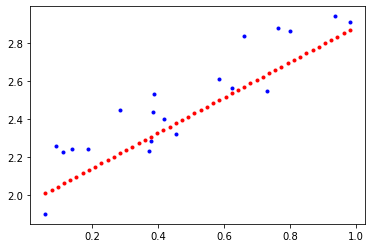

In [29]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [60]:
# Define the custom layers and model
class MyLayer2(Layer): 
  def __init__(self, units):
    super(MyLayer2, self).__init__()
    self.units = units 

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer='random_normal',
                             name='kernel')
    self.b = self.add_weight(shape=(self.units,),
                             initializer='zeros',
                             name='bias')
    
  def call(self, inputs):
    return tf.matmul(inputs, self.w)+self.b

class MyDropout2(Layer):

    def __init__(self, rate):
        super(MyDropout2, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)


class MyModel2(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel2, self).__init__()
        # Define layers
        self.layer_1 = MyLayer2(units_1)
        self.dropout_1 = MyDropout2(0.5)
        self.layer_2 = MyLayer2(units_2)
        self.dropout_2 = MyDropout2(0.5)
        self.layer_3 = MyLayer2(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)


In [61]:
# instantiate the model object 

model2 = MyModel2(64, 64, 46)
print(model2(tf.ones((1, 10000))))
model2.summary()

tf.Tensor(
[[0.01585483 0.01839561 0.01846101 0.03021801 0.01810575 0.02729023
  0.01389111 0.02718361 0.01674212 0.01147136 0.01952974 0.02119783
  0.02170798 0.03557801 0.03140333 0.01552987 0.0139772  0.02891845
  0.01232679 0.0194061  0.01608179 0.02774366 0.01815069 0.0175981
  0.01712133 0.02288105 0.02429253 0.02832611 0.0185816  0.01758051
  0.0170457  0.03238706 0.04601184 0.02228258 0.02529028 0.01498011
  0.01151842 0.02044862 0.03054928 0.01170362 0.02859696 0.02533758
  0.01612531 0.02244771 0.02774953 0.02197921]], shape=(1, 46), dtype=float32)
Model: "my_model2_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer2_3 (MyLayer2)       multiple                  640064    
_________________________________________________________________
my_dropout2_2 (MyDropout2)   multiple                  0         
_________________________________________________________________
my_layer2_4 (MyLay

#### Load the reuters dataset and define the class_names 

In [62]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [63]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [64]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

In [65]:
# Print the first data example sentence

print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [66]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [67]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [68]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [69]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# keep results for plotting 
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Training loop
  for x, y in train_dataset:
    #optimize the model
    loss_value, grads = grad(model2, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model2.trainable_variables))

    #compute current loss
    epoch_loss_avg(loss_value)
    # compare predicted label to acutal label
    epoch_accuracy(to_categorical(y), model2(x))
  # end epoch 
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss {:.3f} Accuracy: {:.3%}".format(epoch, 
                                                            epoch_loss_avg.result(), 
                                                            epoch_accuracy.result()))
    
    
print("Duration :{:.3f}".format(time.time() - start_time))


Epoch 000: Loss 3.295 Accuracy: 49.544%
Epoch 001: Loss 1.931 Accuracy: 61.211%
Epoch 002: Loss 1.834 Accuracy: 65.553%
Epoch 003: Loss 1.778 Accuracy: 68.136%
Epoch 004: Loss 1.756 Accuracy: 68.715%
Epoch 005: Loss 1.730 Accuracy: 69.417%
Epoch 006: Loss 1.726 Accuracy: 69.673%
Epoch 007: Loss 1.719 Accuracy: 70.129%
Epoch 008: Loss 1.707 Accuracy: 70.318%
Epoch 009: Loss 1.694 Accuracy: 70.675%
Duration :59.840


#### Evaluate the model

In [70]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [71]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [72]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 8.856
Test accuracy: 4.319%


#### Plot the learning curves

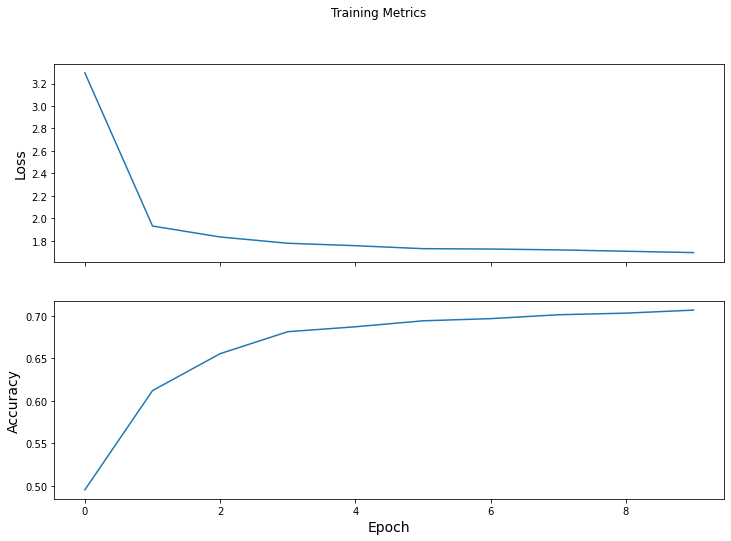

In [73]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [74]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: veg-oil
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
# Initialize a new model
model2 = MyModel2(64, 64, 46)


#### Redefine the grad function using the @tf.function decorator

In [77]:
# Use the @tf.function decorator
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


#### Train the model

In [78]:
# Re-run the training loop
from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# keep results for plotting 
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

  # Training loop
  for x, y in train_dataset:
    #optimize the model
    loss_value, grads = grad(model2, x, y, weight_decay)
    optimizer.apply_gradients(zip(grads, model2.trainable_variables))

    #compute current loss
    epoch_loss_avg(loss_value)
    # compare predicted label to acutal label
    epoch_accuracy(to_categorical(y), model2(x))
  # end epoch 
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  print("Epoch {:03d}: Loss {:.3f} Accuracy: {:.3%}".format(epoch, 
                                                            epoch_loss_avg.result(), 
                                                            epoch_accuracy.result()))
    
    
print("Duration :{:.3f}".format(time.time() - start_time))



Epoch 000: Loss 2.422 Accuracy: 56.502%
Epoch 001: Loss 1.932 Accuracy: 64.696%
Epoch 002: Loss 1.836 Accuracy: 67.791%
Epoch 003: Loss 1.785 Accuracy: 68.904%
Epoch 004: Loss 1.755 Accuracy: 69.005%
Epoch 005: Loss 1.742 Accuracy: 69.528%
Epoch 006: Loss 1.718 Accuracy: 69.840%
Epoch 007: Loss 1.713 Accuracy: 70.207%
Epoch 008: Loss 1.702 Accuracy: 70.407%
Epoch 009: Loss 1.692 Accuracy: 70.330%
Duration :41.612


#### Print the autograph code

In [80]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

